In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
len(os.listdir("/content/drive/MyDrive/chest_xray/train/PNEUMONIA"))

3895

# Data Visualization


Train set:
PNEUMONIA=3895
NORMAL=1359
Test set:
PNEUMONIA=390
NORMAL=244
Validation set:
PNEUMONIA=8
NORMAL=8


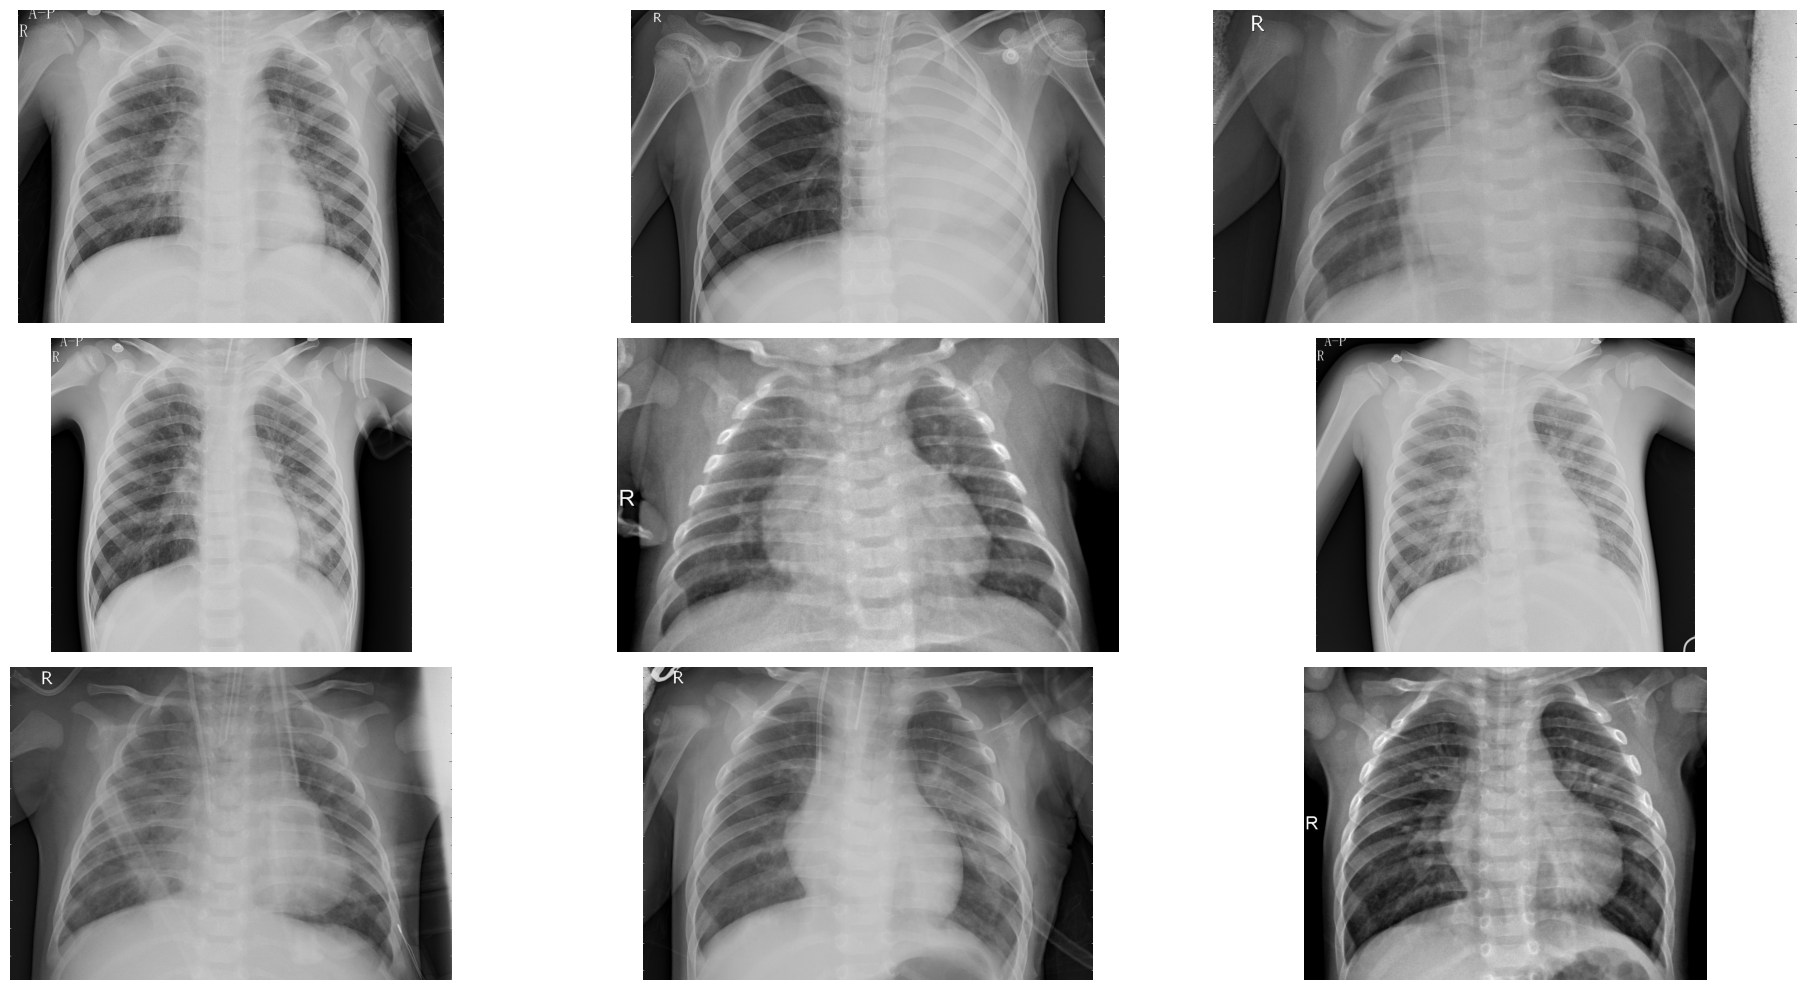

In [ ]:
train_dir = "/content/drive/MyDrive/chest_xray/train"
test_dir = "/content/drive/MyDrive/chest_xray/test"
val_dir = "/content/drive/MyDrive/chest_xray/val"

print("Train set:\n========================================")
num_pneumonia = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))
num_normal = len(os.listdir(os.path.join(train_dir, 'NORMAL')))
print(f"PNEUMONIA={num_pneumonia}")
print(f"NORMAL={num_normal}")

print("Test set:\n========================================")
print(f"PNEUMONIA={len(os.listdir(os.path.join(test_dir, 'PNEUMONIA')))}")
print(f"NORMAL={len(os.listdir(os.path.join(test_dir, 'NORMAL')))}")

print("Validation set:\n========================================")
print(f"PNEUMONIA={len(os.listdir(os.path.join(val_dir, 'PNEUMONIA')))}")
print(f"NORMAL={len(os.listdir(os.path.join(val_dir, 'NORMAL')))}")

pneumonia = os.listdir("/content/drive/MyDrive/chest_xray/train/PNEUMONIA")
pneumonia_dir = "/content/drive/MyDrive/chest_xray/train/PNEUMONIA"

plt.figure(figsize=(20, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(pneumonia_dir, pneumonia[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')

plt.tight_layout()

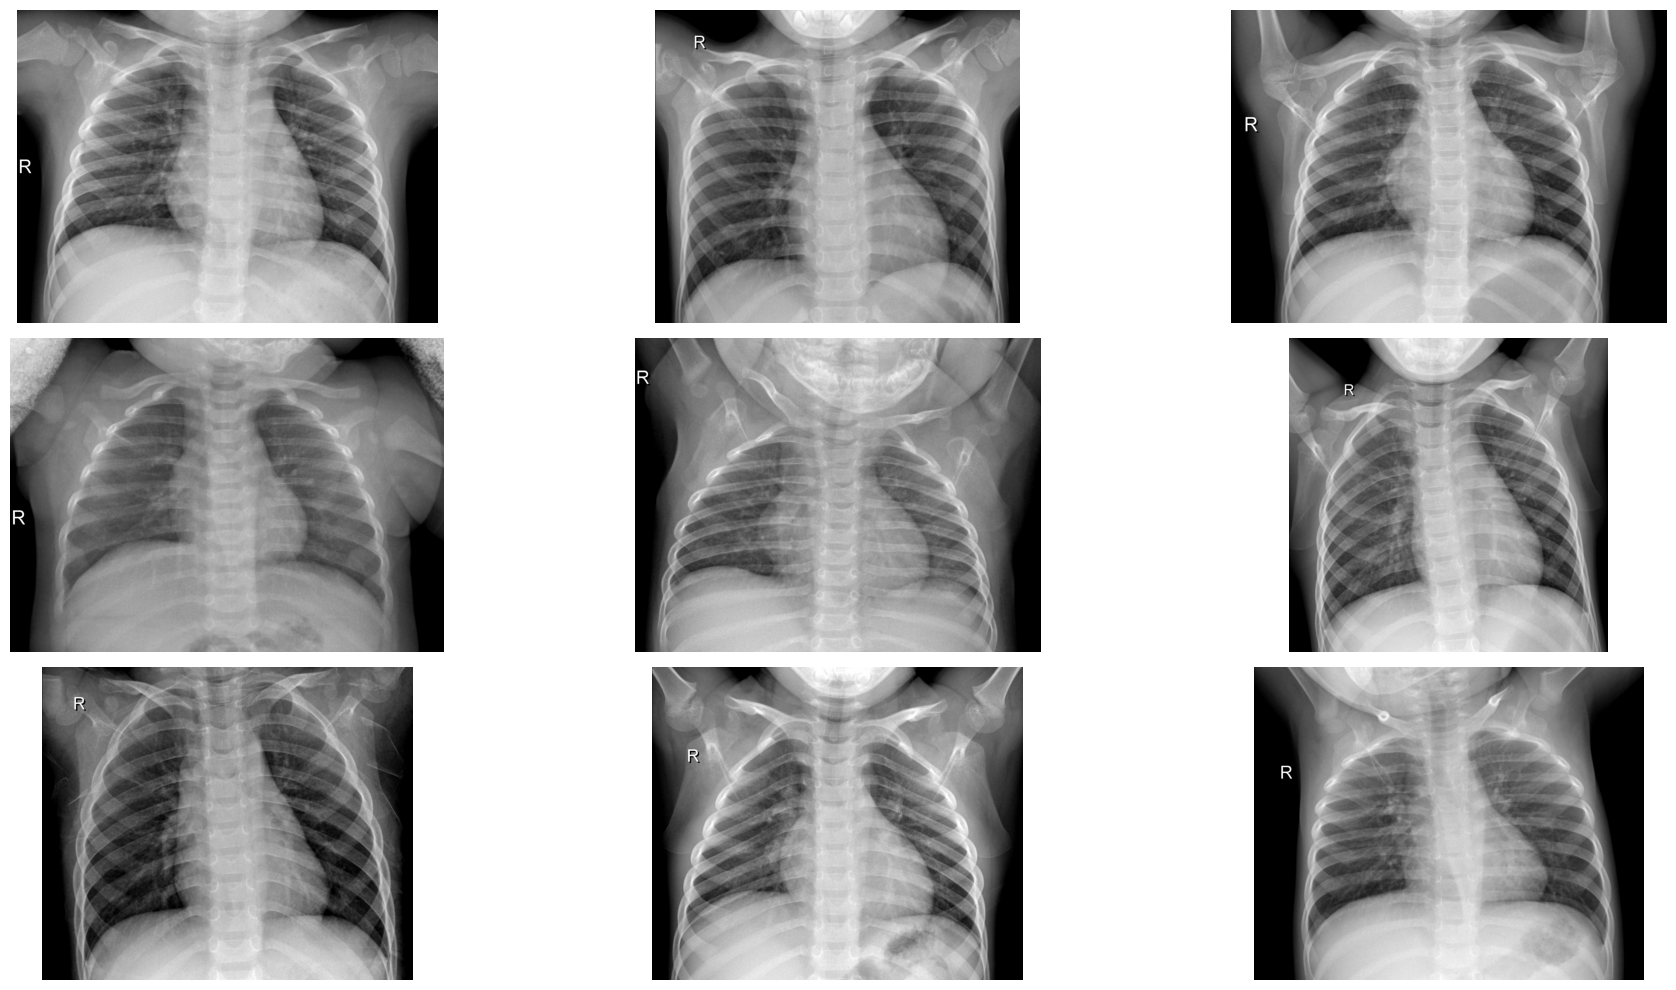

In [ ]:
normal = os.listdir("/content/drive/MyDrive/chest_xray/train/NORMAL")
normal_dir = "/content/drive/MyDrive/chest_xray/train/NORMAL"

plt.figure(figsize=(20, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(normal_dir, normal[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')

plt.tight_layout()

The dimensions of the image are 1406 pixels width and 1886 pixels height, one single color channel.
The maximum pixel value is 255.0000 and the minimum is 0.0000
The mean value of the pixels is 130.6984 and the standard deviation is 61.3062


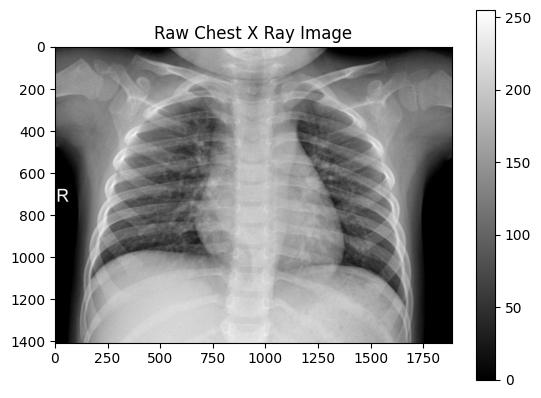

In [ ]:
normal_img = os.listdir("/content/drive/MyDrive/chest_xray/train/NORMAL")[0]
normal_dir = "/content/drive/MyDrive/chest_xray/train/NORMAL"
sample_img = plt.imread(os.path.join(normal_dir, normal_img))
plt.imshow(sample_img, cmap='gray')
plt.colorbar()
plt.title('Raw Chest X Ray Image')

print(f"The dimensions of the image are {sample_img.shape[0]} pixels width and {sample_img.shape[1]} pixels height, one single color channel.")
print(f"The maximum pixel value is {sample_img.max():.4f} and the minimum is {sample_img.min():.4f}")
print(f"The mean value of the pixels is {sample_img.mean():.4f} and the standard deviation is {sample_img.std():.4f}")

# Ivestigate pixel value distribution

Text(0, 0.5, '# Pixels in Image')

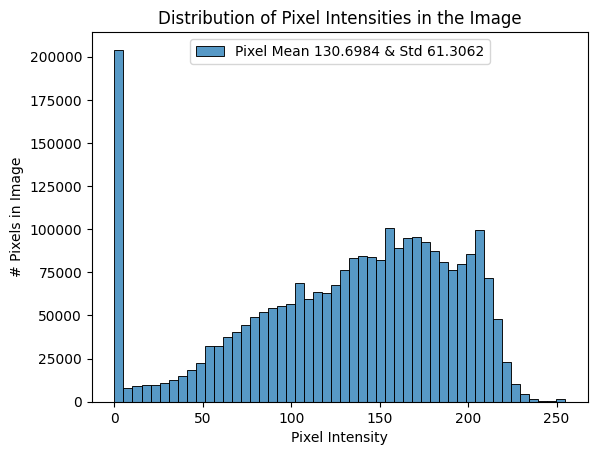

In [ ]:
import numpy as np

# Flatten the image and clean data
pixel_values = sample_img.ravel()
pixel_values = pixel_values[np.isfinite(pixel_values)]

# Now plot
sns.histplot(pixel_values,
             label=f"Pixel Mean {np.mean(pixel_values):.4f} & Std {np.std(pixel_values):.4f}",
             kde=False, bins=50)

plt.legend(loc='upper center')
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixels in Image')

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    samplewise_center=True,
    samplewise_std_normalization=True
)


# Build a separate generator fo valid and test sets

In [ ]:
train = image_generator.flow_from_directory(train_dir,
                                            batch_size=8,
                                            shuffle=True,
                                            class_mode='binary',
                                            target_size=(180, 180))

validation = image_generator.flow_from_directory(val_dir,
                                                batch_size=1,
                                                shuffle=False,
                                                class_mode='binary',
                                                target_size=(180, 180))

test = image_generator.flow_from_directory(test_dir,
                                            batch_size=1,
                                            shuffle=False,
                                            class_mode='binary',
                                            target_size=(180, 180))

Found 5254 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 634 images belonging to 2 classes.


The dimensions of the image are 180 pixels width and 180 pixels height, one single color channel.
The maximum pixel value is 2.7414 and the minimum is -3.1731
The mean value of the pixels is 0.0000 and the standard deviation is 1.0000


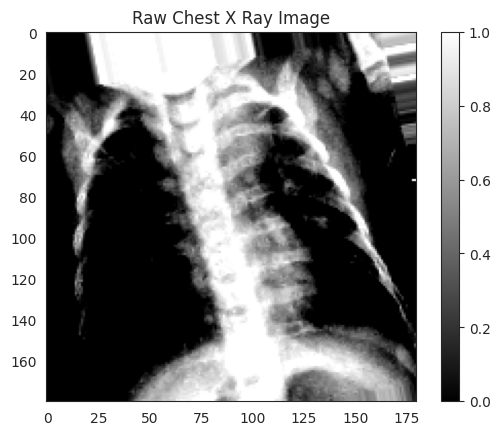

In [ ]:
sns.set_style('white')
generated_image, label = train.__getitem__(0)
plt.imshow(generated_image[0], cmap='gray')
plt.colorbar()
plt.title('Raw Chest X Ray Image')

print(f"The dimensions of the image are {generated_image.shape[1]} pixels width and {generated_image.shape[2]} pixels height, one single color channel.")
print(f"The maximum pixel value is {generated_image.max():.4f} and the minimum is {generated_image.min():.4f}")
print(f"The mean value of the pixels is {generated_image.mean():.4f} and the standard deviation is {generated_image.std():.4f}")

# CNN model

In [ ]:
# Class weights

weight_for_0 = num_pneumonia / (num_normal + num_pneumonia)
weight_for_1 = num_normal / (num_normal + num_pneumonia)

class_weight = {0: weight_for_0, 1: weight_for_1}

print(f"Weight of class 0: {weight_for_0:.2f}")
print(f"Weight of class 1: {weight_for_1:.2f}")

Weight of class 0: 0.74
Weight of class 1: 0.26


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, Dropout, Flatten, BatchNormalization

model = Sequential()

# Use an Input layer to define the input shape
model.add(Input(shape=(180, 180, 3)))

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 178, 178, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 176, 176, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 176, 176, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 88, 88, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 86, 86, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 86, 86, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 84, 84, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 84, 84, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 42, 42, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 40, 40, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 40, 40, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 38, 38, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 38, 38, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 19, 19, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 46208)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     5,914,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,203,681 (23.67 MB)

 Trainable params: 6,202,785 (23.66 MB)

 Non-trainable params: 896 (3.50 KB)

In [ ]:
r = model.fit(
    train,
    epochs=10,
    validation_data=validation,
    class_weight=class_weight,
    steps_per_epoch=50,
    validation_steps=25
)

Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 192ms/step - accuracy: 0.9376 - loss: 0.0831 - val_accuracy: 0.6250 - val_loss: 1.0034
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 183ms/step - accuracy: 0.9782 - loss: 0.0401 - val_accuracy: 0.5625 - val_loss: 2.3385
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 190ms/step - accuracy: 0.9403 - loss: 0.0717 - val_accuracy: 0.6250 - val_loss: 0.9172
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 201ms/step - accuracy: 0.9480 - loss: 0.0579 - val_accuracy: 0.6250 - val_loss: 0.9298
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 182ms/step - accuracy: 0.9262 - loss: 0.0764 - val_accuracy: 0.6250 - val_loss: 1.3900
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 157ms/step - accuracy: 0.9162 - loss: 0.0840 - val_accuracy: 0.5000 - val_loss: 1.2825
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 192ms/step - accuracy: 0.9279 - loss: 0.0797 - val_accuracy: 0.8125 - val_loss: 0.3740
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 204ms/step - accuracy: 0.9217 - loss: 0.0757 - val_accuracy:

# Evaluation

Text(0.5, 1.0, 'Accuracy Evolution')

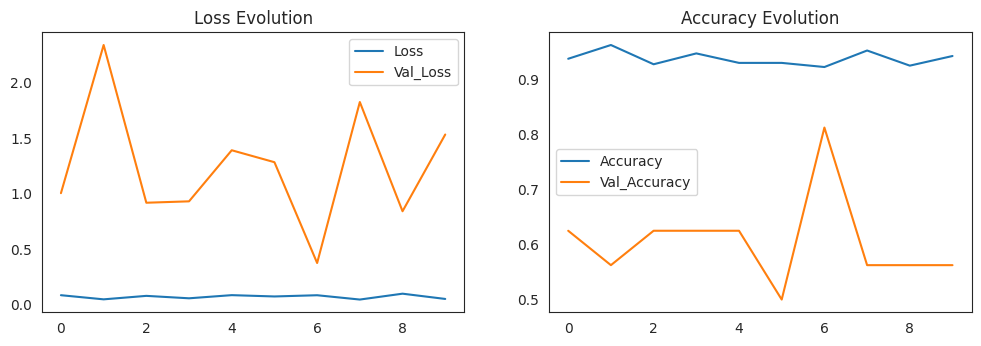

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(r.history['accuracy'], label='Accuracy')
plt.plot(r.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [ ]:
evaluation = model.evaluate(test)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = model.evaluate(train)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

634/634 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - accuracy: 0.7761 - loss: 0.7813
Test Accuracy: 84.07%
657/657 ━━━━━━━━━━━━━━━━━━━━ 102s 155ms/step - accuracy: 0.8916 - loss: 0.3551
Train Accuracy: 89.89%


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

pred = model.predict(test)

print(confusion_matrix(test.classes, pred > 0.5))
pd.DataFrame(classification_report(test.classes, pred > 0.5, output_dict=True))

634/634 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step
[[102 142]
 [  6 384]]


,0,1,accuracy,macro avg,weighted avg
precision,0.944444,0.730038,0.766562,0.837241,0.812554
recall,0.418033,0.984615,0.766562,0.701324,0.766562
f1-score,0.579545,0.838428,0.766562,0.708987,0.738795
support,244.000000,390.000000,0.766562,634.000000,634.000000


In [ ]:
print(confusion_matrix(test.classes, pred > 0.7))
pd.DataFrame(classification_report(test.classes, pred > 0.7, output_dict=True))

[[156  88]
 [ 15 375]]


,0,1,accuracy,macro avg,weighted avg
precision,0.912281,0.809935,0.837539,0.861108,0.849324
recall,0.639344,0.961538,0.837539,0.800441,0.837539
f1-score,0.751807,0.879250,0.837539,0.815528,0.830202
support,244.000000,390.000000,0.837539,634.000000,634.000000


Text(0.5, 1.0, 'Accuracy Evolution')

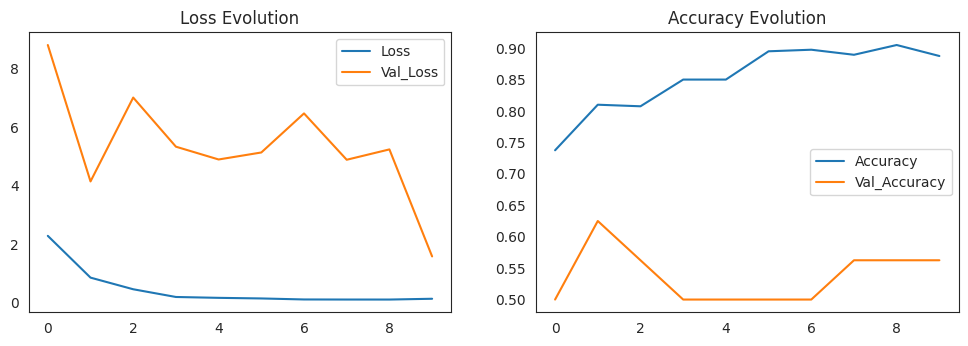

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(r.history['accuracy'], label='Accuracy')
plt.plot(r.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')